# Transformer Summarizer

<div style="text-align:center;">
<img src = "./media/transformerNews.png" width="600px">
</div>


In [1]:
!pip install -q trax

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.10.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.10.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.27.0 which is incompatible.
flax 0.6.0 requires rich~=11.1, but you have rich 12.1.0 which is incompatible.


## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp
import textwrap

2022-09-10 17:39:24.877527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-09-10 17:39:24.921785: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-10 17:39:26.206153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-09-10 17:39:26.206453: W tensorflow/stream_executor/platfor

## Import Data

In [3]:
# Download data from Kaggle

TRAIN_DATA_PATH = '../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'
EVALUATION_DATA_PATH = '../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv'
TEST_DATA_PATH = '../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
eval_df = pd.read_csv(EVALUATION_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

## EDA

In [5]:
# Remove 'id' column

train_df.drop(columns=['id'], inplace=True)
eval_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

In [6]:
# Check out data

train_df.head()

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [7]:
# Check for presence of null values

print(f'train_df:\n{train_df.isna().sum()}\n\n')
print(f'eval_df:\n{eval_df.isna().sum()}\n\n')
print(f'test_df:\n{test_df.isna().sum()}\n\n')

train_df:
article       0
highlights    0
dtype: int64


eval_df:
article       0
highlights    0
dtype: int64


test_df:
article       0
highlights    0
dtype: int64




## Build Data Generator

In [8]:
# train_stream_fn = trax.data.TFDS(
#     dataset_name='cnn_dailymail',
#     data_dir='../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail',
#     keys=('article', 'highlights'),
#     train=True
# )

# eval_stream_fn = trax.data.TFDS(
#     dataset_name='cnn_dailymail',
#     data_dir='../input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail',
#     keys=('article', 'highlights'),
#     train=False
# )

In [9]:
## Create Data Generator Functions

def datagen_fn(data):
    def datagen(data=data):
        for row_idx in range(len(data)):
            yield data.iloc[row_idx,0], data.iloc[row_idx, 1]
    return datagen

In [10]:
# Test the generator funtion

test_datagen_fn = datagen_fn(data=test_df)
test_datagen = test_datagen_fn()
test_datagen

<generator object datagen_fn.<locals>.datagen at 0x7f523eab3650>

In [11]:
print('First sample from data generator:\n\n',next(test_datagen))
print('\n\nSecond sample from data generator:\n\n',next(test_datagen))

First sample from data generator:

 ("Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to mor

## Preprocessing Data

In [12]:
# Utility Functions

wrapper = textwrap.TextWrapper(width=70)

def tokenize(input_str, EOS=1):
    # the trax.data.tokenize method takes streams and returns streams.
    # we get around it by making a 1-element stream with `iter`.
    
    # inputs is a numpy array
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_dir='./vocab_dir',
                                      vocab_file='summarize32k.subword.subwords'))
    return list(inputs) + [EOS]


def detokenize(integers_list):
    text = trax.data.detokenize(integers_list,
                                  vocab_dir='./vocab_dir',
                                  vocab_file='summarize32k.subword.subwords')
    return wrapper.fill(text)

In [13]:
print('Special Characters in the Vocabulary:\n')
print(f'{detokenize([0])} -> 0')
print(f'{detokenize([1])} -> 1')

Special Characters in the Vocabulary:

<pad> -> 0
<EOS> -> 1


In [14]:
# Test tokenize and detokenize

print(f'tokenize("How are you") = {tokenize("How are you")}')
print(f'\ndetokenize([791, 1435, 33, 1]) = {detokenize([791, 1435, 33, 1])}')

tokenize("How are you") = [791, 1435, 33, 1]

detokenize([791, 1435, 33, 1]) = How are you<EOS>


#### To create inputs for the Transformer Decoder model, we create a single input suitable for a language model, we concatenate inputs with targets putting a separator in between. We also need to create a mask -- with 0s at inputs and 1s at targets -- so that the model is not penalized for mis-predicting the article and only focuses on the summary.

**[Article] -> \<EOS> -> \<pad> -> [Article Summary] -> \<EOS> -> (possibly) multiple \<pad>**

In [15]:
SEP = 0 # Padding or separator token
EOS = 1 # End of sentence token

def preprocess(datastream):
    # datastream provides samples of strings tokenized to tensors.
    for (article, highlights) in datastream:
        inputs = np.array(list(article) + [EOS, SEP] + list(highlights) + [EOS])
        weights = np.array([0] * (len(article) + 2) + [1] * (len(highlights) + 1))
        yield inputs, inputs, weights  # return x, y, weights 
        

In [16]:
# combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    # Here we don't use our custom function since that handles strings and uses trax.data.tokenize
    # Below "Tokenize" takes a generator as input and returns a tokenize generator function
    trax.data.Tokenize(vocab_dir='./vocab_dir',
                       vocab_file='summarize32k.subword.subwords'),
    
    # Uses function defined above
    preprocess,
    
    # Filters out examples longer than 2048
    trax.data.FilterByLength(2048),
    
    # Bucketing to create batched generators.
    # Buckets are defined in terms of boundaries and batch sizes.
    # Batch_sizes[i] determines the batch size for items with length < boundaries[i]
    # So below, we'll take a batch of 16 sentences of length < 128 , 8 of length < 256,
    # 4 of length < 512. And so on. 
    trax.data.BucketByLength(boundaries=[128, 256,  512, 1024], batch_sizes=[16,    8,    4,    2, 1])
)

train_batch_stream = input_pipeline(datagen_fn(train_df)())
eval_batch_stream = input_pipeline(datagen_fn(eval_df)())

In [17]:
# Check out the output of the input pipeline
train_input, train_target, train_mask = next(train_batch_stream)

print(f'Shape of train_input = {train_input.shape}')
print(f'Shape of train_target = {train_target.shape}')
print(f'Shape of train_mask = {train_mask.shape}')

# prints mask, 0s on article, 1s on summary
print(f'Single example mask:\n\n {train_mask[0]}')

# prints: [Example][<EOS>][<pad>][Example Summary][<EOS>]
print(f'Single example:\n\n {detokenize(train_input[0])}')

Shape of train_input = (1, 1201)
Shape of train_target = (1, 1201)
Shape of train_mask = (1, 1201)
Single example mask:

 [0 0 0 ... 1 1 1]
Single example:

 A drunk driver who killed a young woman in a head-on crash while
checking his mobile phone has been jailed for six years. Craig
Eccleston-Todd, 27, was driving home from a night at a pub when he
received a text message. As he was reading or replying to it, he
veered across the road while driving round a bend and smashed into
Rachel Titley’s car coming the other way. Craig Eccleston-Todd, 27
(left) was using his mobile phone when he crashed head-on into the car
being driven by Rachel Titley, 28 (right). She died later from her
injuries . The head-on crash took place in October 2013. Mr Eccleston-
Todd's car was barely recognisable (pictured) Police said Eccleston-
Todd had drunk at least three or four pints of beer before getting
behind the wheel. He was found guilty of causing death by dangerous
driving at Portsmouth Crown Court y

The train input and train output has the following structure.

- **[Article] -> \<EOS> -> \<pad> -> [Article Summary] -> \<EOS> -> (possibly) multiple \<pad>**

## Understanding the trax.data.Serial Pipeline

In [18]:
# Demo Part1
dummy_inputstream = iter([('hello world', 'how', 'are'), 'world hello'])

# >> next(dummy_inputstream) --> (hello','world', 'how', 'are')
# >> next(dummy_inputstream) --> 'world'

# function that takes input as generator, outputs a generator
tokenizer_fn = trax.data.Tokenize(vocab_dir='./vocab_dir',
                       vocab_file='summarize32k.subword.subwords')

tokenizer_gen = tokenizer_fn(dummy_inputstream)

print(f'type(tokenizer_fn) = {type(tokenizer_fn)}\n')
print(f'type(tokenizer_gen) = {type(tokenizer_gen)}\n')


dummy_output = tokenizer_gen
print(f'output for first input = {next(dummy_output)}\n')
print(f'output for second input = {next(dummy_output)}')

type(tokenizer_fn) = <class 'function'>

type(tokenizer_gen) = <class 'generator'>

output for first input = (array([22611,    79,   175]), array([7270]), array([1435]))

output for second input = [  175 22611    79]


In [19]:
# Demo Part2

# Demonstrating chaining of generators.

# Note items in input stream needs to be exactly two as preprocess function expects tuples of 2 items.
dummy_inputstream = iter([('hello','world'), ('super', 'fun')])

# function that takes input as generator, outputs a generator
tokenizer_fn = trax.data.Tokenize(vocab_dir='./vocab_dir',
                       vocab_file='summarize32k.subword.subwords')

tokenizer_gen = tokenizer_fn(dummy_inputstream)


# preprocess is a function takes input as generator i.e tokenizer_gen, outputs a generator i.e. dummy_output
dummy_output = preprocess(tokenizer_gen)

# Get results from resultant generator
print(f'output for first input = {next(dummy_output)}\n')
print(f'output for second input = {next(dummy_output)}')


output for first input = (array([22611,    79,     1,     0,   175,     1]), array([22611,    79,     1,     0,   175,     1]), array([0, 0, 0, 0, 1, 1]))

output for second input = (array([6377,    1,    0, 2037,    1]), array([6377,    1,    0, 2037,    1]), array([0, 0, 0, 1, 1]))


**This is what essentially the trax.data.Serial pipeline does.**

## Summarization with transformer

<div style="text-align:center">
<img src="./media/transformer_decoder_zoomin.png" width="700px">
</div>

### Dot product attention

<div style="text-align:center">
<img src='./media/dotproduct.png' width="500px"/>
</div>

The formula for attention is:
$$Attention(Q, K, V)=softmax\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{1}$$

- $d_{k}$ - dimension of queries and keys.
- $Q$ - Query
- $K$ - Key
- $V$ - Value
- $M$ - Mask

Something to take into consideration is that within trax, **the masks are tensors of `True/False` values not 0's and -$\infty$.** We don't apply the mask by summing up matrices, instead we use `jnp.where()` and treat **the mask as a tensor of boolean values with `False` for values that need to be masked and `True` for the ones that don't.**

**Instead of `.T` for transposing we use `jnp.matmul()` and `jnp.swapaxes()` instead.**

In [20]:
def DotProductAttention(query, key, value, mask=False):
    # Dimension of query = (batch, heads, query_seq_len, depth of query(dq))
    # Dimension of key = (batch, heads, key_seq_len, depth of key(dk))
    # Dimension of value = (batch, heads, value_seq_len, depth of value(dv))     
    # Dimension of mask = (1, query_seq_len, key_seq_len) 
    
    # key_seq_len = value_seq_len
    
    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"
    
    dk = key.shape[-1]
    
    qk_matmul = jnp.matmul(query, jnp.swapaxes(key, -1, -2))  # (batch, heads, query_seq_len, key_seq_len)
    
    scaled_qk_matmul = qk_matmul / jnp.sqrt(dk)
    
    if mask is not None:
        # mask is brodcasted to match dimension of scaled_qk_matmul
        scaled_qk_matmul = jnp.where(mask, scaled_qk_matmul, jnp.full_like(scaled_qk_matmul, -1e9))
    
    logsumexp = trax.fastmath.logsumexp(scaled_qk_matmul, axis=-1, keepdims=True)
    
    attention_weights = jnp.exp(scaled_qk_matmul - logsumexp) # (batch, heads, query_seq_len, key_seq_len)
    
    attention_outputs = jnp.matmul(attention_weights, value)  # (batch, heads, query_seq_len, dv)
    
    return attention_outputs
        

In [21]:
# Test above code

q = np.array([[[[1, 0, 0], [0, 1, 0]]]])  # (batch, heads, query_seq_len, dq) = (1,1,2,3)
k = np.array([[[[1, 2, 3], [4, 5, 6]]]])
v = np.array([[[[0, 1, 0], [1, 0, 1]]]])
m = np.array([[[True, False], [True, True]]])  # (batch, query_seq_len, key_seq_len) = (1,2,2)

attention_outputs = DotProductAttention(q, k, v, m)
print(f'attention_outputs = \n{attention_outputs}')

attention_outputs = 
[[[[0.         1.         0.        ]
   [0.8496746  0.15032543 0.8496746 ]]]]


## Causal Multi Head Attention

Causal multi-headed attention is carried out with a mask to attend only to words that occurred before.

<div style="text-align:center">
    <img src="./media/causal.png" width="500px">
</div>

This is achieved in 3 steps:
1. **split_into_heads**
2. **dot_product_self_attention**
3. **merge_heads**

- **split_into_heads** : Gets an input of dimension (n_batch, seqlen, n_heads x d_head) and splits the last (depth) dimension and arrages to transform the dimension to (n_batch, n_heads, seqlen, d_head).


In [22]:
def split_into_heads(n_heads=8):
    def _split_into_heads(x):
        # Dimension of x = (batch, seq_len, d_model)
        # Splits d_model to (n_heads x d_head) and 
        # arrage x to output (batch, n_heads, seq_len, d_model)

        batch_dim = x.shape[0]
        d_model = x.shape[-1]
        assert d_model % n_heads == 0, f"dimension of input cannot be split into {n_heads} heads"

        d_head = d_model // n_heads

        split_x = jnp.reshape(x, (batch_dim, -1, n_heads, d_head))
        split_x = jnp.transpose(split_x, (0,2,1,3))

        return split_x
    return _split_into_heads
    

In [23]:
# Test above code

q = np.array([[[1, 0, 0, 1, 2, 1], [0, 1, 0, 1, 1, 0]]])  # (batch, query_seq_len, d_model) = (1,2,6)
k = np.array([[[1, 2, 3, 4, 5, 6], [4, 5, 6, 7, 8, 9]]])  # (batch, key_seq_len, d_model) = (1,2,6)
v = np.array([[[0, 1, 0, 0, 0, 0], [1, 0, 1, 1, 2, 3]]])
m = np.array([[[True, False], [True, True]]])  # (batch, query_seq_len, key_seq_len) = (1,2,2)

q_split = split_into_heads(n_heads=3)(q)  # (1, 3, 2, 2) 
k_split = split_into_heads(n_heads=3)(k)
v_split = split_into_heads(n_heads=3)(v)

print(f'q = \n{q}\n')
print(f'q_split = \n{q_split}')

q = 
[[[1 0 0 1 2 1]
  [0 1 0 1 1 0]]]

q_split = 
[[[[1 0]
   [0 1]]

  [[0 1]
   [0 1]]

  [[2 1]
   [1 0]]]]


- **dot_product_self_attention** : Creates a mask matrix with `False` values above the diagonal and `True` values below and calls `DotProductAttention` which implements dot product self attention.


In [24]:
def dot_product_self_attention(q, k, v):
    # q, k, v have dimensions (batch, heads, seq_len, d_head)
    
    mask = jnp.tril(jnp.ones((1, q.shape[-2], k.shape[-2]), dtype=bool))   # (q_seq_len, k_seq_len)
    
    return DotProductAttention(q, k, v, mask)
    

In [25]:
# Test above code

attention_output = dot_product_self_attention(q_split, k_split, v_split)
attention_output  # (batch, n_heads, seq_len, dv) = (1,3,2,2)

DeviceArray([[[[0.        , 1.        ],
               [0.8929583 , 0.10704182]],

              [[0.        , 0.        ],
               [0.8929583 , 0.8929583 ]],

              [[0.        , 0.        ],
               [1.7859166 , 2.678875  ]]]], dtype=float32)

- **merge_heads** : Undoes `split_into_heads` by transposing and transforming the dimension from (n_batch, n_heads, seqlen, d_head) to (n_batch, seqlen, n_heads x d_head) = (n_batch, seqlen, d_model)

In [26]:
def merge_heads(n_heads=8):
    def _merge_heads(x):
        # x: (batch, n_heads, seq_len, d_head) -> (batch, seq_len, d_model)
        batch_dim = x.shape[0]
        d_head = x.shape[-1]
        
        merged_x = jnp.transpose(x, (0, 2, 1, 3))
        
        merged_x = jnp.reshape(merged_x, (batch_dim, -1, n_heads * d_head))
        
        return merged_x
    return _merge_heads
       

In [27]:
# Test above code

atten_output = q_split   # (batch, n_heads, seq_len, dv) = (1,3,2,2)

atten_output_concat = merge_heads(n_heads=3)(atten_output)
atten_output_concat  # (batch, seq_len, d_model) = (1,3,2,6)

DeviceArray([[[1, 0, 0, 1, 2, 1],
              [0, 1, 0, 1, 1, 0]]], dtype=int32)

### Causal Attention Function

<div style="text-align:center">
    <img src="./media/masked-attention.png" width="200px">
</div>

In [28]:
def CausalMultiHeadAttention(d_model,
                             n_heads, 
                             split_into_heads=split_into_heads,
                             dot_product_self_attention=dot_product_self_attention,
                             merge_heads=merge_heads,
                             mode='train'):
    
    assert d_model % n_heads == 0
    d_head = d_model // n_heads
    
    split_into_heads = tl.Fn('AttnHeads', split_into_heads(n_heads), n_out=1)
    
    mha = tl.Serial(
        tl.Branch(
            [tl.Dense(d_model), split_into_heads],  # Q: (batch, seq_len, d_model)
            [tl.Dense(d_model), split_into_heads],  # K: (batch, seq_len, d_model)
            [tl.Dense(d_model), split_into_heads]   # V: (batch, seq_len, d_model)
        ),
        tl.Fn('ScaledDotProductAttn', dot_product_self_attention, n_out=1),
        tl.Fn('MergeAttnHeads', merge_heads(n_heads), n_out=1),
        tl.Dense(d_model)
    )
    return mha

In [29]:
# View Model

print(CausalMultiHeadAttention(d_model=512, n_heads=8))

Serial[
  Branch_out3[
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
  ]
  ScaledDotProductAttn_in3
  MergeAttnHeads
  Dense_512
]


## Understanding trax.Branch

In [30]:
dummy_mha = tl.Serial(
    tl.Branch(
        tl.Dense(3, use_bias=False),
        tl.Dense(3, use_bias=False),
        tl.Dense(3, use_bias=False)
    )
)

In [31]:
x = np.array([[1,2],[2,3]])
dummy_mha.init(trax.shapes.signature(x))

dummy_mha(x) # takes single input applies to all the layers in the branch

(DeviceArray([[-0.43780887, -1.8338552 ,  2.9939942 ],
              [-0.11149305, -2.794222  ,  4.9539194 ]], dtype=float32),
 DeviceArray([[-0.04623963,  1.4642413 , -1.8378723 ],
              [-0.08563728,  2.6276815 , -3.0543737 ]], dtype=float32),
 DeviceArray([[ 0.42390916,  2.0448813 , -0.8350952 ],
              [ 0.47652954,  3.3159573 , -1.6388589 ]], dtype=float32))

In [32]:
# operates only on first input, additional inputs are returned as is.
dummy_mha((x,x,x))

(DeviceArray([[-0.43780887, -1.8338552 ,  2.9939942 ],
              [-0.11149305, -2.794222  ,  4.9539194 ]], dtype=float32),
 DeviceArray([[-0.04623963,  1.4642413 , -1.8378723 ],
              [-0.08563728,  2.6276815 , -3.0543737 ]], dtype=float32),
 DeviceArray([[ 0.42390916,  2.0448813 , -0.8350952 ],
              [ 0.47652954,  3.3159573 , -1.6388589 ]], dtype=float32),
 array([[1, 2],
        [2, 3]]),
 array([[1, 2],
        [2, 3]]))

## Transformer decoder block

<div style="text-align:center">
    <img src="./media/transformer_decoder_1.png" width="150px">
</div>


In [33]:
def FeedForward(d_model,
                dff,
                dropout,
                ff_activation,
                mode='train'):
    # dff: depth of first dense layer in feed forward network.
    ffw = tl.Serial(
        tl.LayerNorm(),
        tl.Dense(dff),
        ff_activation(),
        tl.Dropout(dropout, mode=mode),
        tl.Dense(d_model),
        tl.Dropout(dropout, mode=mode)
    )
    return ffw

In [34]:
# Test above code

print(FeedForward(1,2,0.3, tl.Relu))

Serial[
  LayerNorm
  Dense_2
  Serial[
    Relu
  ]
  Dropout
  Dense_1
  Dropout
]


### Understanding layers combined in list

In [35]:
dummy_ffw = tl.Serial([tl.LayerNorm(),
                       tl.Dense(2),
                       tl.Relu(),
                       tl.Dropout(0.3),
                       tl.Dense(1),
                       tl.Dropout(0.3)],
                      tl.Select([0]) 
                     )
print(dummy_ffw)

Serial[
  LayerNorm
  Dense_2
  Serial[
    Relu
  ]
  Dropout
  Dense_1
  Dropout
  Select[0]
]


In [36]:
x = np.arange(6).reshape(2,3)

print(f'x = \n{x}\n')

dummy_serial = tl.Serial(tl.ShiftRight(),
                         tl.ShiftRight())

dummy_list = tl.Serial([tl.ShiftRight(),
                        tl.ShiftRight()])

print(f'dummy_serial = \n{dummy_serial(x)}\n')
print(f'dummy_list = \n{dummy_list(x)}')

x = 
[[0 1 2]
 [3 4 5]]

dummy_serial = 
[[0 0 0]
 [0 0 3]]

dummy_list = 
[[0 0 0]
 [0 0 3]]


**Hence both serial and serial with list outputs same results**

## Decoder Block

In [37]:
def DecoderBlock(d_model,
                 n_heads,
                 dff,
                 ff_activation,
                 dropout,
                 split_into_heads=split_into_heads,
                 dot_product_self_attention=dot_product_self_attention,
                 merge_heads=merge_heads,
                 mode='train'):
    
    mha = CausalMultiHeadAttention(d_model,
                                   n_heads, 
                                   split_into_heads=split_into_heads,
                                   dot_product_self_attention=dot_product_self_attention,
                                   merge_heads=merge_heads,
                                   mode='train')
    
#     # as per block diagram
#     decoder_orig = tl.Serial(
#         tl.Residual(mha, tl.Dropout(dropout, mode)),
#         tl.Residual(FeedForward(d_model, dff, dropout, ff_activation, mode)),
#         tl.LayerNorm()
#     )
    
    
    # there is difference in implementation
    decoder = tl.Serial(
        tl.Residual(
            tl.LayerNorm(),
            mha,
            tl.Dropout(dropout, mode=mode)),
        tl.Residual(
            FeedForward(d_model, dff, dropout, ff_activation, mode)),
    )


    # using list
#     decoder = [
#         tl.Residual(
#             tl.LayerNorm(),
#             mha,
#             tl.Dropout(dropout, mode=mode)
#         ),
#         tl.Residual(
#             FeedForward(d_model, dff, dropout, ff_activation, mode)
#         )
#     ]
    return decoder

In [38]:
# Take a look at the decoder block

print(DecoderBlock(d_model=512, dff=2048, n_heads=8, dropout=0.1, mode='train', ff_activation=tl.Relu))

Serial[
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
          ]
          ScaledDotProductAttn_in3
          MergeAttnHeads
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
]


In [39]:
# Test above code

x = np.arange(8).reshape(2,4)

decoder = DecoderBlock(d_model=4, dff=2, n_heads=2, dropout=0.2, mode='train', ff_activation=tl.Relu)
decoder.init(trax.shapes.signature(x))

decoder(x)

DeviceArray([[[-1.3693488 ,  0.6269769 ,  2.7946868 , -0.60241747],
              [ 2.630651  ,  4.626977  ,  8.212442  ,  4.0929885 ]],

             [[ 0.        ,  1.4034857 ,  0.78361344,  0.99106884],
              [ 4.        ,  2.2397788 ,  4.7836137 ,  4.991069  ]]],            dtype=float32)

## Transformer Language Model

<div style="text-align:center">
    <img src="./media/transformer_decoder.png" width="200px">
</div>

In [40]:
def positional_encoder(vocab_size, emb_dim, dropout, max_len, mode='train'):
    pos_enc_layer = tl.Serial(
        tl.Embedding(vocab_size, emb_dim),
        tl.Dropout(dropout, mode=mode),
        tl.PositionalEncoding(max_len, mode=mode)
    )
    
#     pos_enc_layer = [
#         tl.Embedding(vocab_size, emb_dim),
#         tl.Dropout(dropout, mode=mode),
#         tl.PositionalEncoding(max_len, mode=mode)
#     ]
    return pos_enc_layer

In [41]:
# Test above code

x = np.arange(6).reshape(2,3)
print(f'x =\n{x}\n')

dummy_pos_enc_layer = positional_encoder(10, 4, 0.5, 10, mode='train')
dummy_pos_enc_layer.init(trax.shapes.signature(x))

dummy_pos_enc_layer(x)

x =
[[0 1 2]
 [3 4 5]]



DeviceArray([[[ 1.3769149 ,  1.9009633 ,  0.4347727 ,  1.        ],
              [ 0.84147096, -0.5079986 ,  0.00999983, -0.5057369 ],
              [ 0.9092974 , -0.41614684,  1.6510981 ,  0.28994936]],

             [[ 0.        ,  1.        ,  0.        ,  1.        ],
              [ 1.8106987 ,  0.53254163, -0.31743684,  0.99995   ],
              [ 0.9092974 , -0.5560785 ,  0.01999867,  0.8145319 ]]],            dtype=float32)

In [42]:
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  dff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """
    vocab_size (int): vocab size.
    d_model (int):  depth of embedding.
    d_ff (int): depth of feed-forward layer.
    n_layers (int): number of decoder layers.
    n_heads (int): number of attention heads.
    dropout (float): dropout rate (how much to drop out).
    max_len (int): maximum symbol length for positional encoding.
    mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
    ff_activation (function): the non-linearity in feed-forward layer.
    """
    
    pos_enc = positional_encoder(vocab_size, d_model, dropout, max_len, mode='train')
    
    decoder_blocks = [DecoderBlock(d_model, n_heads, dff, ff_activation, dropout, mode='train') for _ in range(n_layers)]
    
    lm_model = tl.Serial(tl.ShiftRight(),
                         pos_enc,
                         decoder_blocks,
                         tl.LayerNorm(),
                         tl.Dense(vocab_size),
                         tl.LogSoftmax()        # (batch, val_seq_len, d_model)
                         )
    return lm_model

In [43]:
# Take a look at the Transformer
print(TransformerLM(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Serial[
    Embedding_33300_512
    Dropout
    PositionalEncoding
  ]
  Serial[
    Serial[
      Branch_out2[
        None
        Serial[
          LayerNorm
          Serial[
            Branch_out3[
              [Dense_512, AttnHeads]
              [Dense_512, AttnHeads]
              [Dense_512, AttnHeads]
            ]
            ScaledDotProductAttn_in3
            MergeAttnHeads
            Dense_512
          ]
          Dropout
        ]
      ]
      Add_in2
    ]
    Serial[
      Branch_out2[
        None
        Serial[
          LayerNorm
          Dense_2048
          Serial[
            Relu
          ]
          Dropout
          Dense_512
          Dropout
        ]
      ]
      Add_in2
    ]
  ]
  LayerNorm
  Dense_33300
  LogSoftmax
]


In [44]:
# Test above code.

x = np.arange(6).reshape(2,3)
print(f'x =\n{x}\n')

y = TransformerLM(vocab_size=6,
                  d_model=4,
                  dff=2,
                  n_layers=1,
                  n_heads=2,
                  dropout=0.5,
                  max_len=2096,
                  mode='train',
                  ff_activation=tl.Relu)
y.init(trax.shapes.signature((x,x,x)))
y((x,x,x))  # Note model will accept three inputs (x, y, weights) and operate on only x

x =
[[0 1 2]
 [3 4 5]]



(DeviceArray([[[-2.909063  , -1.7315776 , -1.5850875 , -1.7443916 ,
                -2.8369648 , -1.1081055 ],
               [-3.6034265 , -2.1803663 , -1.3786373 , -1.6741512 ,
                -2.7189717 , -1.0372218 ],
               [-3.6865885 , -2.3224912 , -1.5814284 , -1.8454138 ,
                -2.589747  , -0.825003  ]],
 
              [[-2.6325703 , -1.5625279 , -1.4617455 , -1.6166458 ,
                -2.9059675 , -1.4549582 ],
               [-3.8968985 , -2.5502818 , -1.4106562 , -1.7429168 ,
                -2.3776977 , -0.94191754],
               [-3.4094129 , -2.3453832 , -2.1227496 , -2.241263  ,
                -2.4530141 , -0.58148265]]], dtype=float32),
 array([[0, 1, 2],
        [3, 4, 5]]),
 array([[0, 1, 2],
        [3, 4, 5]]))

## Training

Learning Rate Decay Visualization

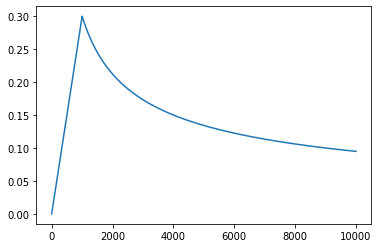

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.3)
lr_list = []
for step in range(10000):
    lr_list.append(lr_schedule(step))

plt.plot(lr_list)

In [46]:
def train_model(TransformerLM, train_gen, eval_gen, output_dir='./model'):
    
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.3)
    
    train_task = trax.supervised.training.TrainTask(labeled_data=train_gen,
                                                    loss_layer=tl.CrossEntropyLoss(),
                                                    optimizer = trax.optimizers.Adam(0.01),
                                                    lr_schedule = lr_schedule,
                                                    n_steps_per_checkpoint=50 )

    eval_task = trax.supervised.training.EvalTask(labeled_data = eval_gen,
                                                  metrics = [tl.CrossEntropyLoss(), tl.Accuracy()])
    
    # parameters set just for quick demo and run
    loop = trax.supervised.training.Loop(TransformerLM(d_model=16,
                                                       dff=16,
                                                       n_layers=2,
                                                       n_heads=2,
                                                       mode='train'),
                                        train_task,
                                        eval_tasks=[eval_task],
                                        output_dir=output_dir)
    return loop
    

In [47]:
# Should take around 1.5 minutes
!rm -drf "./model"
loop = train_model(TransformerLM, train_batch_stream, eval_batch_stream)
loop.run(300)

/opt/conda/lib/python3.7/site-packages/jax/_src/lib/xla_bridge.py:546: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "



Step      1: Total number of trainable weights: 1167860
Step      1: Ran 1 train steps in 18.82 secs
Step      1: train CrossEntropyLoss |  10.41773033
Step      1: eval  CrossEntropyLoss |  10.41375732
Step      1: eval          Accuracy |  0.00000000

Step     50: Ran 49 train steps in 690.90 secs
Step     50: train CrossEntropyLoss |  9.12540627
Step     50: eval  CrossEntropyLoss |  7.38056469
Step     50: eval          Accuracy |  0.04255319

Step    100: Ran 50 train steps in 681.23 secs
Step    100: train CrossEntropyLoss |  7.70083904
Step    100: eval  CrossEntropyLoss |  7.09745121
Step    100: eval          Accuracy |  0.08490566

Step    150: Ran 50 train steps in 603.35 secs
Step    150: train CrossEntropyLoss |  7.30135393
Step    150: eval  CrossEntropyLoss |  7.66794729
Step    150: eval          Accuracy |  0.13157895

Step    200: Ran 50 train steps in 721.81 secs
Step    200: train CrossEntropyLoss |  7.22626352
Step    200: eval  CrossEntropyLoss |  7.19024134
Step

## Evaluation 

In [48]:
# Get the model architecture with same attributes as the one which was trained. Mode set to 'eval'
model = TransformerLM(d_model=16,
                      dff=16,
                      n_layers=2,
                      n_heads=2,
                      mode='eval')

# Load the pre-trained weights
model.init_from_file('./model/model.pkl.gz', weights_only=True)

# model = loop.model

((((), (), ()),
  (array([[ 0.676046  ,  1.6431683 ,  0.90281075, ...,  2.5941877 ,
           -0.68246305, -4.23666   ],
          [-0.53310984, -0.10491635,  0.22503795, ...,  2.169048  ,
           -0.20688346, -0.7905125 ],
          [ 0.3225279 ,  3.093391  , -0.7109899 , ...,  0.8956694 ,
            2.3741393 , -0.41297525],
          ...,
          [-0.22615461,  0.286901  , -0.23882514, ..., -0.34279794,
            0.3137588 , -0.1271572 ],
          [-0.3572138 ,  0.42198524,  0.3359526 , ...,  0.12800308,
           -0.12306768,  0.4254097 ],
          [ 0.09528735,  0.06841756, -0.07917369, ..., -0.25102448,
            0.29469275, -0.17720583]], dtype=float32),
   (),
   array([[-0.00804228,  0.9464318 ,  0.53862077, ...,  1.2180789 ,
            0.51905614,  1.4384325 ],
          [ 0.285745  ,  1.801126  ,  0.4563031 , ...,  3.9193602 ,
            0.35339507,  1.6664958 ],
          [-0.3158809 , -0.45889637,  0.8490797 , ..., -0.23722284,
           -1.4654164 ,  0.62

In [49]:
def next_symbol(cur_output_tokens, model):
    """Returns the next symbol for a given sentence.

    Args:
        cur_output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
        model (trax.layers.combinators.Serial): The transformer model.

    Returns:
        int: tokenized symbol.
    """
    len_cur_seq = len(cur_output_tokens)
    
    # calculate the minimum power of 2 big enough to store token_length
    # add 1 to token_length so jnp.log2() doesn't receive 0 when token_length is 0
    padded_length = 2 ** int(jnp.ceil(jnp.log2(len_cur_seq + 1)))
    
    padded_cur_output_tokens = cur_output_tokens + (padded_length - len_cur_seq) * [0]
    
    padded_batch_cur_output_tokens = jnp.array(padded_cur_output_tokens)[None,...]  # convert list to trax array and add batch dimension
    
    # The model takes inputs (x, y, weights) to produce (output of model on x, y, weights) for loss calculation layer.
    # Here we can feed just (x) to model to produce (output of model on x)
    # Dimension of output (1, padded_length, vocab_size)
    # We select the last word before padding starts i.e. len_cur_seq
    next_word_pred_probs = model(padded_batch_cur_output_tokens)[0, len_cur_seq, :]
    
    next_word_idx = jnp.argmax(next_word_pred_probs)  # greedy decoding
    
    return next_word_idx

In [58]:
# Test it out!
sentence_test_nxt_symbl = "I want to board the"
detokenize([next_symbol(tokenize(sentence_test_nxt_symbl)+[0], model)])

' .'

In [51]:
def greedy_decode(input_sentence, model, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Greedy decode function.

    Args:
        input_sentence (string): a sentence or article.
        model (trax.layers.combinators.Serial): Transformer model.

    Returns:
        string: summary of the input.
    """
    SEP = 0
    EOS = 1
    
    next_word_idx = 0
    summary = []
    
    tokenized_input = tokenize(input_sentence, EOS=1)  # returns a list of word idx tokens
    tokenized_input += [SEP]
    
    while next_word_idx != EOS and len(summary) < 100:
        next_word_idx = next_symbol(tokenized_input, model)
        tokenized_input.append(next_word_idx)
        summary.append(next_word_idx)
#         print(detokenize(summary))
    
    return detokenize(summary)

In [61]:
# Test it out on a sentence!
test_sentence = "I went to the shop. I went to play."
print(f'Article:\n{wrapper.fill(test_sentence)}')
print(f'\nSummary of Article:\n{greedy_decode(test_sentence, model)}')

Article:
I went to the shop. I went to play.

Summary of Article:
the . . .10;the the . the the .\10 .\10 . .\10 .\10 . . . .\10 . the
the the the .  .  . the the the . the .\10 .  .\10 . the .10;the the
the the .  . the .  .


**It can be seen that if the model is trained on larger parameters it would be able to summarize the article**